In [1]:
import os
import torch
import random
import numpy as np
from torch.utils.data import DataLoader
from torch import nn

from pose.dataset import pose_dataset
from pose.utils import collate_fn, geodesic_distance, relative_pose_error
from pose.model import Mkpts_Reg_Model
from pose.animator import Animator


if os.name == 'nt':
    LM_dataset_path = 'd:/git_project/POPE/data/LM_dataset/'
    LM_dataset_json_path = 'd:/git_project/POPE/data/pairs/LINEMOD-test.json'
    LM_dataset_points_path = 'd:/git_project/POPE/data/LM_dataset-points/'

    onepose_path = 'd:/git_project/POPE/data/onepose/'
    onepose_json_path = 'd:/git_project/POPE/data/pairs/Onepose-test.json'
    onepose_points_path = 'd:/git_project/POPE/data/onepose-points/'

    onepose_plusplus_path = 'd:/git_project/POPE/data/onepose_plusplus/'
    onepose_plusplus_json_path = 'd:/git_project/POPE/data/pairs/OneposePlusPlus-test.json'
    onepose_plusplus_points_path = 'd:/git_project/POPE/data/onepose_plusplus-points/'

    ycbv_path = 'd:/git_project/POPE/data/ycbv/'
    ycbv_json_path = 'd:/git_project/POPE/data/pairs/YCB-VIDEO-test.json'
    ycbv_points_path = 'd:/git_project/POPE/data/ycbv-points'
elif os.name == 'posix':
    LM_dataset_path = 'data/LM_dataset/'
    LM_dataset_json_path = 'data/pairs/LINEMOD-test.json'
    LM_dataset_points_path = 'data/LM_dataset-points/'

    onepose_path = 'data/onepose/'
    onepose_json_path = 'data/pairs/Onepose-test.json'
    onepose_points_path = 'data/onepose-points/'

    onepose_plusplus_path = 'data/onepose_plusplus/'
    onepose_plusplus_json_path = 'data/pairs/OneposePlusPlus-test.json'
    onepose_plusplus_points_path = 'data/onepose_plusplus-points/'

    ycbv_path = 'data/ycbv/'
    ycbv_json_path = 'data/pairs/YCB-VIDEO-test.json'
    ycbv_points_path = 'data/ycbv-points'

paths = [
    # ('linemod', LM_dataset_path, LM_dataset_json_path, LM_dataset_points_path),
    # ('onepose', onepose_path, onepose_json_path, onepose_points_path),
    ('onepose_plusplus', onepose_plusplus_path, onepose_plusplus_json_path, onepose_plusplus_points_path),
    # ('ycbv', ycbv_path, ycbv_json_path, ycbv_points_path),
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = pose_dataset(paths)
mkpts_max_len, mkpts_sum_len = dataset.get_mkpts_info()

 56%|█████▌    | 5/9 [00:05<00:04,  1.08s/it]

d:/git_project/POPE/data/onepose_plusplus-points/0706-teabox-box\mkpts0\820.png-761.png.txt does not exist


 89%|████████▉ | 8/9 [00:07<00:00,  1.09it/s]

d:/git_project/POPE/data/onepose_plusplus-points/0712-insta-others\mkpts0\1570.png-125.png.txt does not exist


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]

d:/git_project/POPE/data/onepose_plusplus-points/0712-insta-others\mkpts0\1605.png-185.png.txt does not exist
d:/git_project/POPE/data/onepose_plusplus-points/0712-insta-others\mkpts0\1628.png-210.png.txt does not exist


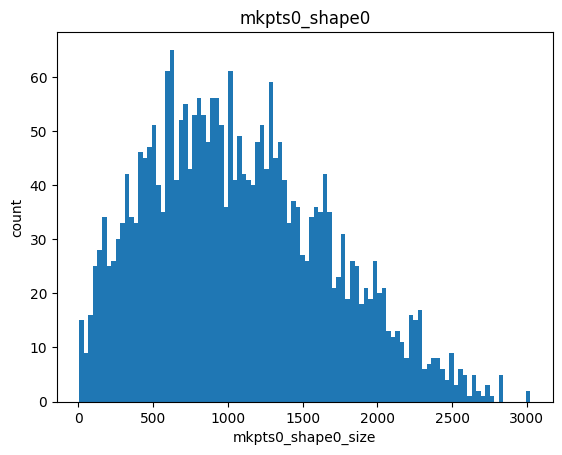

In [2]:
from matplotlib import pyplot as plt

mkpts0_shape0 = []
for data in dataset:
    mkpts0_shape0.append(data['mkpts0'].shape[0])

# 可视化mkpts0_shape0
plt.figure()
plt.title('mkpts0_shape0')
plt.xlabel('mkpts0_shape0_size')
plt.ylabel('count')
plt.hist(mkpts0_shape0, bins=100)
plt.show()

In [3]:
random.seed(20231223)
torch.manual_seed(20231223)
torch.cuda.manual_seed(20231223)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [4]:
num_sample = 300
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_fn(num_sample))
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_fn(num_sample))

In [5]:
net = Mkpts_Reg_Model(num_sample=num_sample, mode='6d').to(device)
net.train()

L2 = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-6, weight_decay=1e-6)

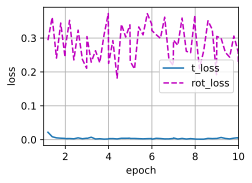

In [6]:
num_epochs = 10
model_type = 'relative_r-gt_t'

animator = Animator(xlabel='epoch', ylabel='loss',
                    xlim=[1, num_epochs],
                    legend=['t_loss', 'rot_loss'])

for epoch in range(1, num_epochs + 1):
    for i, batch in enumerate(train_dataloader):
        # if i == 1: break

        batch_K0 = []
        batch_K1 = []
        batch_pose0 = []
        batch_pose1 = []
        batch_mkpts0 = []
        batch_mkpts1 = []
        batch_pre_K = []

        for data in batch:
            batch_K0.append(data['K0'])
            batch_K1.append(data['K1'])
            # print(data['pose0'].shape)
            if data['pose0'].shape[0] == 3:
                data['pose0'] = np.vstack((data['pose0'], np.array([0, 0, 0, 1])))
            if data['pose1'].shape[0] == 3:
                data['pose1'] = np.vstack((data['pose1'], np.array([0, 0, 0, 1])))
            batch_pose0.append(data['pose0'])
            batch_pose1.append(data['pose1'])
            batch_mkpts0.append(data['mkpts0'])
            batch_mkpts1.append(data['mkpts1'])
            batch_pre_K.append(data['pre_K'])

        batch_K0 = torch.from_numpy(np.stack(batch_K0, axis=0)).float().to(device)
        batch_K1 = torch.from_numpy(np.stack(batch_K1, axis=0)).float().to(device)

        if model_type == 'gt':
            batch_pose0 = torch.from_numpy(np.stack(batch_pose0, axis=0)).float().to(device)
            batch_pose1 = torch.from_numpy(np.stack(batch_pose1, axis=0)).float().to(device)

            gt_rot = batch_pose1[:, :3, :3]
            gt_t = batch_pose1[:, :3, 3]
        elif model_type == 'relative':
            batch_pose0 = np.stack(batch_pose0, axis=0)
            batch_pose1 = np.stack(batch_pose1, axis=0)
            batch_relative_pose = np.matmul(batch_pose1, np.linalg.inv(batch_pose0))
            batch_relative_pose = torch.from_numpy(batch_relative_pose).float().to(device)

            gt_rot = batch_relative_pose[:, :3, :3]
            gt_t = batch_relative_pose[:, :3, 3]
        elif model_type == 'relative_r-gt_t':
            batch_pose0 = np.stack(batch_pose0, axis=0)
            batch_pose1 = np.stack(batch_pose1, axis=0)
            batch_relative_pose = np.matmul(batch_pose1, np.linalg.inv(batch_pose0))
            batch_relative_pose = torch.from_numpy(batch_relative_pose).float().to(device)
            batch_pose1 = torch.from_numpy(batch_pose1).float().to(device)

            gt_rot = batch_relative_pose[:, :3, :3]
            gt_t = batch_pose1[:, :3, 3]

        batch_mkpts0 = torch.from_numpy(np.stack(batch_mkpts0, axis=0)).float().to(device)
        batch_mkpts1 = torch.from_numpy(np.stack(batch_mkpts1, axis=0)).float().to(device)

        batch_pre_K = torch.from_numpy(np.stack(batch_pre_K, axis=0)).float().to(device)

        pre_t, pre_rot = net(batch_mkpts0, batch_mkpts1)

        t_loss = L2(gt_t, pre_t)
        rot_loss = geodesic_distance(gt_rot, pre_rot)

        loss = t_loss + rot_loss
        # loss = t_loss
        # loss = rot_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % (len(train_dataloader) // 5) == 0 or i == len(train_dataloader) - 1:
            animator.add(epoch + (i + 1) / len(train_dataloader),
                        (t_loss.item(), rot_loss.item()))
        # print(f'epoch: {epoch}, batch: {i + 1}, t_loss: {t_loss.item()}, rot_loss: {rot_loss.item()}, loss: {loss.item()}')

In [7]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d-%H-%M-%S")
torch.save(net, f'./weights/{model_type}-{net.mode}-{num_sample}-{dt_string}-{loss:.4f}.pth')